In [2]:
# Setup
import pandas as pd
import numpy as np
import git
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load OSX 3D keypoints

In [3]:
# Load 3D joint outputs from OSX (num_videos x num_frames x num_joints (=65) x num_coordinates(=3))
# Each video is flattened to a single row of entry

pickle_path = '/home/ubuntu/OSX/output/STS_test6/log/'
joint_3d_out = np.array(pickle.load(open(os.path.join(pickle_path, "joint_3d_out.p"), "rb")))
video_list_3d = pickle.load(open(os.path.join(pickle_path, "video_list_3d.p"), "rb"))

num_samples = joint_3d_out.shape[0]
joint_3d_out = joint_3d_out.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
joint_3d_out_pd = pd.DataFrame(joint_3d_out)
joint_3d_out_pd.insert(0, 'subjectid', video_list_3d)

print(joint_3d_out_pd.shape)
joint_3d_out_pd


(349, 160876)


,subjectid,0,1,2,3,4,5,6,7,8,...,160865,160866,160867,160868,160869,160870,160871,160872,160873,160874
0,5k0NQN5p,7.165117,8.128481,7.999576,7.310206,8.872834,7.675260,6.645895,8.527279,8.536700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5ghmRK1h,4.842662,7.728497,7.999820,5.451775,8.048058,8.486820,4.496512,8.396622,7.770909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyqYkUq8,7.240149,8.336241,7.999797,7.671251,9.038478,7.808042,6.697642,8.754007,8.508330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ovgMFqBi,4.953118,8.166962,8.000340,5.577065,8.395662,8.568070,4.647401,8.975616,7.823025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZK2JlJsq,4.936371,7.099742,8.000220,5.520699,7.578927,8.663420,4.262356,7.828258,7.946367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,CAMRbQ1K,6.500200,7.752910,8.000870,6.998765,8.366642,7.755850,5.927775,8.250779,8.223240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,uBFpj4lx,4.941953,7.931615,7.999839,5.722272,8.326239,8.212730,4.531985,8.563694,7.683910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,CWf3eyvo,5.219727,8.025900,7.999862,5.938199,8.266890,8.293710,4.751878,8.667288,7.705093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,bqTsXpKl,6.932800,7.879572,8.000360,7.389689,8.474448,7.839578,6.268540,8.225052,8.360550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Survey Data (labels)

In [4]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [5]:
# join the dataframes by subjectId 
df_join = joint_3d_out_pd.set_index('subjectid').join(df_survey.set_index('subjectid'), how='inner')
print(df_join.shape)
df_join

(349, 160876)


,0,1,2,3,4,5,6,7,8,9,...,160866,160867,160868,160869,160870,160871,160872,160873,160874,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
5k0NQN5p,7.165117,8.128481,7.999576,7.310206,8.872834,7.675260,6.645895,8.527279,8.536700,4.190158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5ghmRK1h,4.842662,7.728497,7.999820,5.451775,8.048058,8.486820,4.496512,8.396622,7.770909,8.113709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
nyqYkUq8,7.240149,8.336241,7.999797,7.671251,9.038478,7.808042,6.697642,8.754007,8.508330,5.486351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ovgMFqBi,4.953118,8.166962,8.000340,5.577065,8.395662,8.568070,4.647401,8.975616,7.823025,8.808135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ZK2JlJsq,4.936371,7.099742,8.000220,5.520699,7.578927,8.663420,4.262356,7.828258,7.946367,8.503104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMRbQ1K,6.500200,7.752910,8.000870,6.998765,8.366642,7.755850,5.927775,8.250779,8.223240,5.504666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
uBFpj4lx,4.941953,7.931615,7.999839,5.722272,8.326239,8.212730,4.531985,8.563694,7.683910,8.528066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
CWf3eyvo,5.219727,8.025900,7.999862,5.938199,8.266890,8.293710,4.751878,8.667288,7.705093,8.484241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Data validation 

In [6]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [7]:
# 349 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [8]:
# Check for number of OA positive and number of samples in the dataset
print(df_join['OA_check'].count())  # 349
print(df_join['OA_check'].sum())    # 21
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data['OA_check'].count())  # 279
print(train_data['OA_check'].sum())    # 17

# Validation set - This implies that if the model always predicts 0, it would have 94% val accuracy
print(val_data['OA_check'].count())  # 35
print(val_data['OA_check'].sum())    # 2

# Test set - This implies that if the model always predicts 0, it would have 94% test accuracy
print(test_data['OA_check'].count())  # 35
print(test_data['OA_check'].sum())    # 2

349
21
279
17
35
2
35
2


#### Normalization
Skipped normalization as the data is already within a narrow range. Also, later columns often have very few data points (e.g. 1) making normalization difficult.

#### Create dataloaders

In [9]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

In [10]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 160875]) torch.Size([64])
tensor([[5.9261, 7.4133, 8.0011,  ..., 0.0000, 0.0000, 0.0000],
        [4.7282, 7.8164, 8.0005,  ..., 0.0000, 0.0000, 0.0000],
        [6.7763, 8.0240, 8.0006,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [7.2687, 7.8386, 7.9997,  ..., 0.0000, 0.0000, 0.0000],
        [4.9652, 7.8377, 8.0006,  ..., 0.0000, 0.0000, 0.0000],
        [5.2971, 8.2144, 8.0012,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64) tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


#### Create a manually curated data set
Skipped

#### Create dataloaders with upsampling 

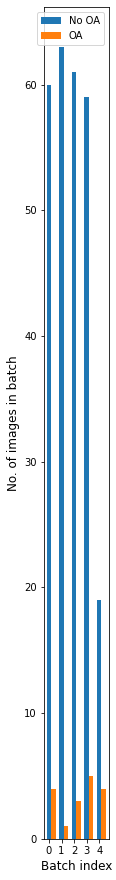

Avg Proportion of No OA per batch: 5.239999999999999
Avg Proportion of OA per batch: 0.34
Num. unique images seen: 279/279


In [18]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

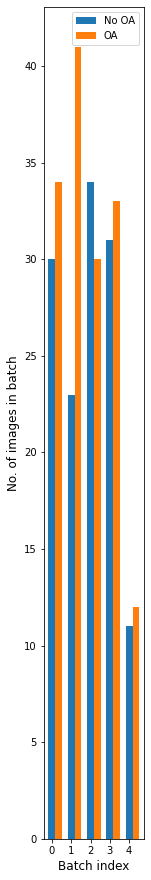

Avg Proportion of No OA per batch: 2.5799999999999996
Avg Proportion of OA per batch: 3.0
Num. unique images seen: 127/279


In [12]:
train = CustomDataset(dataframe=train_data, transform=None)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with unnormalized inputs, no oversampling

In [13]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 8.1789, train_acc = 73.1183, val_acc = 94.2857, train_pos = 22.9391, val_pos = 0.0000
Epoch 1, loss = 0.0000, train_acc = 93.9068, val_acc = 94.2857, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 2.9119, train_acc = 92.4731, val_acc = 94.2857, train_pos = 2.1505, val_pos = 0.0000
Epoch 3, loss = 0.3392, train_acc = 88.8889, val_acc = 94.2857, train_pos = 8.6022, val_pos = 0.0000
Epoch 4, loss = 2.6316, train_acc = 85.3047, val_acc = 94.2857, train_pos = 9.3190, val_pos = 0.0000
Epoch 5, loss = 2.1343, train_acc = 91.3978, val_acc = 94.2857, train_pos = 3.9427, val_pos = 0.0000
Epoch 6, loss = 2.5263, train_acc = 93.9068, val_acc = 94.2857, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = 0.0161, train_acc = 94.6237, val_acc = 91.4286, train_pos = 3.5842, val_pos = 2.8571
Epoch 8, loss = 0.0000, train_acc = 92.1147, val_acc = 94.2857, train_pos = 6.8100, val_pos = 0.0000
Epoch 9, loss = 1.4094, train_acc = 91.7563, val_acc = 88.5714, train_pos = 4.3011, val_po

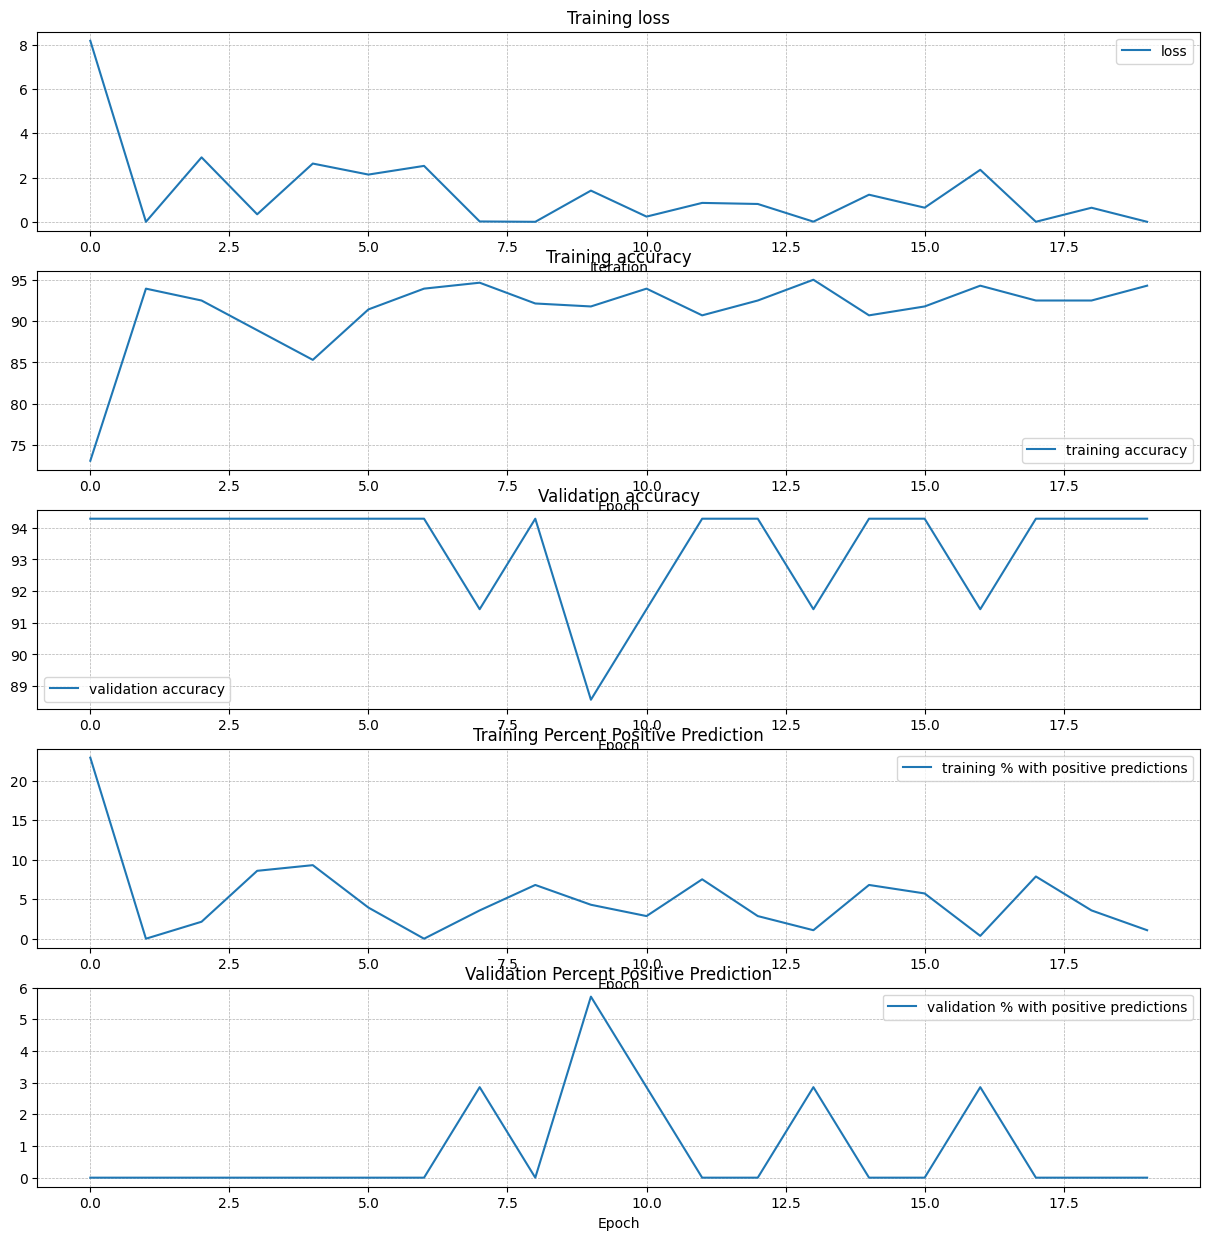

In [14]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, with oversampling

In [23]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 1.3078, train_acc = 48.7455, val_acc = 91.4286, train_pos = 55.5556, val_pos = 2.8571
Epoch 1, loss = 0.6581, train_acc = 58.4229, val_acc = 94.2857, train_pos = 56.9892, val_pos = 0.0000
Epoch 2, loss = 4.1242, train_acc = 53.4050, val_acc = 42.8571, train_pos = 47.3118, val_pos = 62.8571
Epoch 3, loss = 3.2750, train_acc = 65.9498, val_acc = 11.4286, train_pos = 32.2581, val_pos = 94.2857
Epoch 4, loss = 1.5509, train_acc = 61.2903, val_acc = 45.7143, train_pos = 49.1039, val_pos = 60.0000
Epoch 5, loss = 1.2523, train_acc = 69.8925, val_acc = 42.8571, train_pos = 46.5950, val_pos = 62.8571
Epoch 6, loss = 0.7070, train_acc = 68.8172, val_acc = 94.2857, train_pos = 62.0072, val_pos = 5.7143
Epoch 7, loss = 0.7564, train_acc = 77.4194, val_acc = 94.2857, train_pos = 50.1792, val_pos = 5.7143
Epoch 8, loss = 0.8010, train_acc = 73.1183, val_acc = 94.2857, train_pos = 54.4803, val_pos = 0.0000
Epoch 9, loss = 0.7313, train_acc = 71.3262, val_acc = 91.4286, train_pos = 47

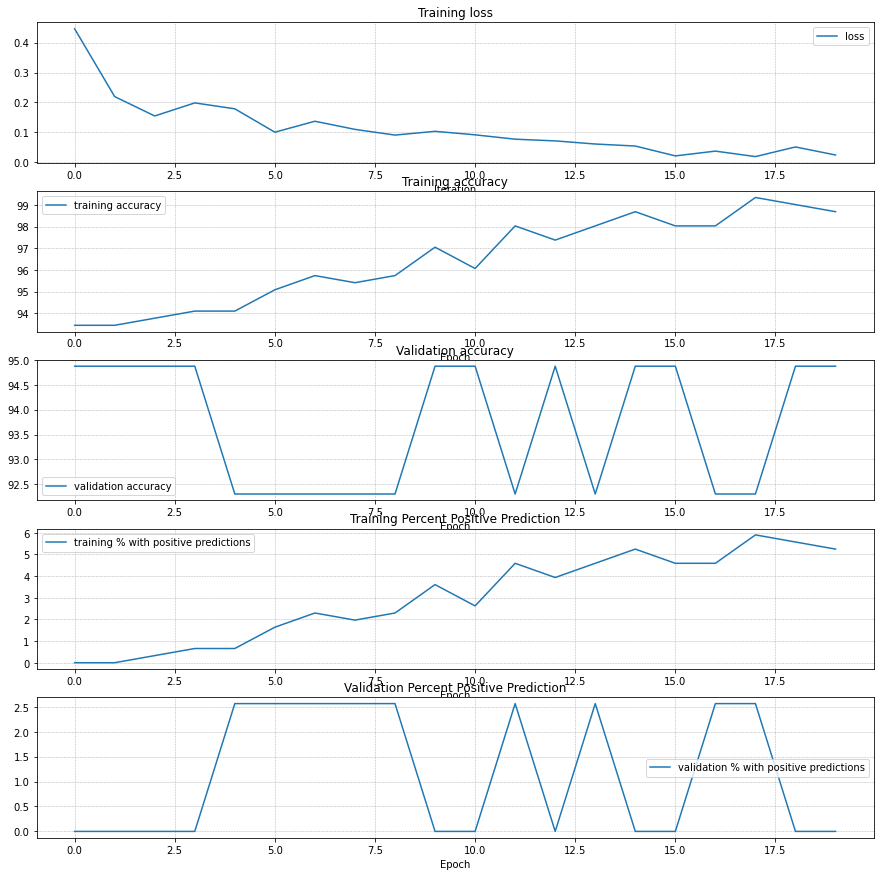

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, with weighted loss

In [22]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

RuntimeError: The size of tensor a (64) must match the size of tensor b (2) at non-singleton dimension 0

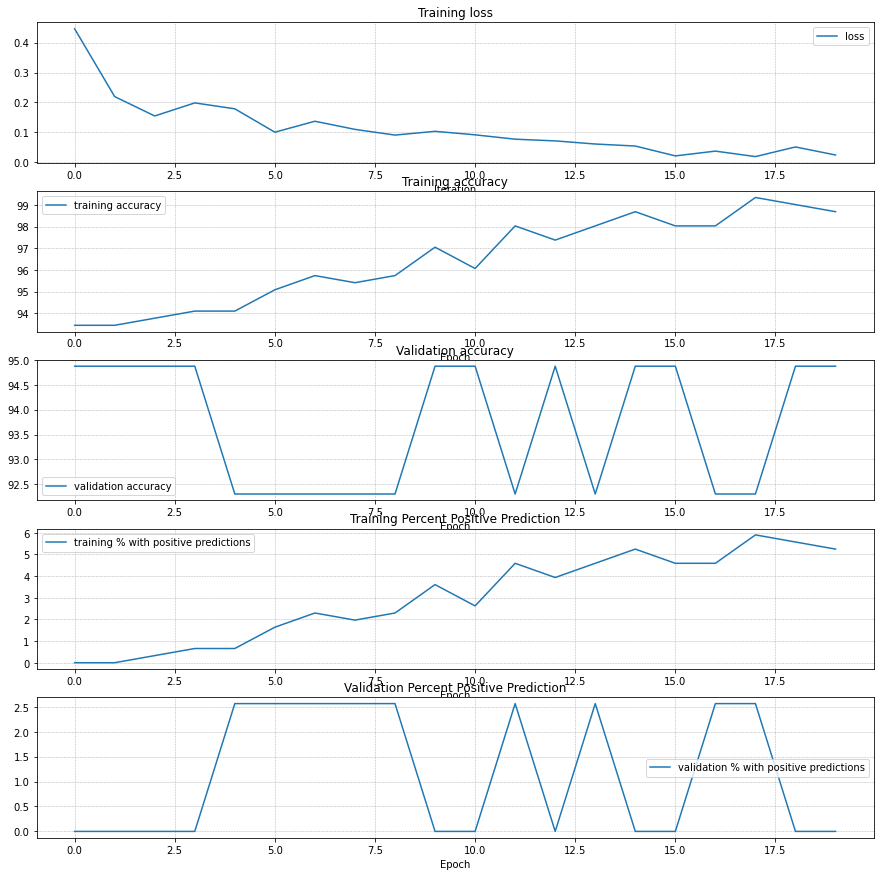

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()